In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer 
from utils import spacy_tokenizer
import spacy
import string
from tqdm import trange, tqdm

sns.set_style('darkgrid')
tokenizer = TweetTokenizer()
nlp = spacy.load("en_core_web_md")

# Gráficas en LaTeX, a veces da problemas, en ese caso comentar y reiniciar kernel
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

In [2]:
# !pip install -U spacy
# !python -m spacy download en_core_web_md

- [Preprocesamiento](#Preprocesamiento)
- [LSTM](#LSTM)
  - [Embeddings](#Embeddings)
  - [Training](#Training)
- [Evaluación](#Evaluación)

<a name="Preprocesamiento"></a>
## Preprocesamiento

El mayor problema son las publicaciones que están como [ ], así que tratamos 3 preprocesamientos distintos (aplicando siempre `remove_symbols`):

1. Dejando [ ] como están:
  - **best-model-try1.pt**, *train*=0.6198, *test*=0.6258.
2. Poner los posts con [ ] como completamente tóxicos:
  - **best-model-try2.pt**, *train*=0.6498 , *test*=0.6526 
3. Dropping [ ] del dataset de training:
  - **best-model-try3.pt**, *train*=0.7260, *test*=0.6459
  
Mejor score en Codalab: 0.6488.

In [3]:
from utils import color_toxic_words, remove_symbols, completely_toxic, separate_words

In [4]:
train = pd.read_csv('../Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('../Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})
evaluation = pd.read_csv('../Datos/tsd_test.csv')

In [5]:
train['spans_clean'] = train['spans']
test['spans_clean'] = test['spans']

In [6]:
# Preprocesamiento-1: dejando [ ] como están

# # Quitamos símbolos
# indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
# train['spans_clean'] = indices_clean

# # Pasamos a minúscula
# train['text'] = train['text'].apply(lambda x:x.lower())

In [7]:
# Preprocesamiento-2: poner los posts con [ ] como completamente tóxicos

clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]
train['spans_clean'] = clean_spans

# Quitamos símbolos
indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
train['spans_clean'] = indices_clean

# Pasamos a minúscula
train['text'] = train['text'].apply(lambda x:x.lower())

In [8]:
# Preprocesamiento-3: quitar las publicaciones [ ] del conjunto de entrenamiento

# indices = [i for i in train.index if len(train.loc[i]['spans']) == 0]
# train = train.drop(indices)

# # Quitamos símbolos
# indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
# train['spans_clean'] = indices_clean

# # Pasamos a minúscula
# train['text'] = train['text'].apply(lambda x:x.lower())

<a name="LSTM"></a>
## LSTM

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch.cuda.current_device(), torch.cuda.get_device_name(0)

dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

<a name="Embeddings"></a>
### Cargar embeddings

Checar [Deep Learning For NLP with PyTorch and Torchtext](https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f).

In [10]:
from torchtext.data import Field

In [11]:
# Descargar embeddings en caso de que no estén, puede tardar un rato

from torchtext.vocab import GloVe
GloVe(name='twitter.27B', dim=200)

In [12]:
# Aquí había un problema, estábamos usando 2 tokenizadores diferentes para sacar los
# embeddings y para preprocesar el texto para entrenar. Pondré el de SpaCy como 
# tokenizador en común con el corpus de 'en_core_web_md'

text_field = Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_md',
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# sadly have to apply preprocess manually
preprocessed_text = train['text'].apply(lambda x: text_field.preprocess(x))
# load fastext simple embedding with 300d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.twitter.27B.200d'
)
# get the vocab instance
vocab = text_field.vocab

/home/david/Documentos/PyTorch-1.x/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [13]:
# El tokenizador hace bien su trabajo, los embeddings existen siempre y cuando la 
# palabra esté en el dataset de entrenamiento
vocab.lookup_indices(["f**k", 'dont', "do", "n't", '...', "are", 'a**hole', 'asshole'])

[4353, 12785, 29, 24, 57, 16, 7312, 980]

<a name="Training"></a>
### Training

Primero preparemos los datos para poder pasárselos a la LSTM.

In [14]:
from torch.utils.data import Dataset, DataLoader
from torch import autograd
import torch.optim as optim
from utils import get_index_toxic_words, f1, f1_scores, plot_loss_and_score

In [15]:
train_data = []
for index, text in tqdm(zip(train['spans_clean'], train['text']), total=len(train)):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = spacy_tokenizer(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens, text, index))

100%|██████████| 7939/7939 [00:48<00:00, 164.80it/s]


In [16]:
test_data = []
for index, text in tqdm(zip(test['spans'], test['text']), total=len(test)):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = spacy_tokenizer(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens, text, index))

100%|██████████| 690/690 [00:04<00:00, 168.18it/s]


In [17]:
def prepare_sequence(seq):
    idxs = vocab.lookup_indices(seq)      # Si no está lo pone como 0
    return torch.tensor(idxs, dtype=torch.long, device=dev)
def prepare_sequence_tags(seq):
    tag_to_ix = {"non_toxic": 0, "toxic": 1} 
    idxs = [tag_to_ix[s] for s in seq]
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [18]:
class SpansDataset(Dataset):
    """Spans dataset."""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        text = prepare_sequence(self.data[idx][0])
        spans = prepare_sequence_tags(self.data[idx][1])
        sample = {'tokenized' : self.data[idx][0], 'original_text' : self.data[idx][2], 'text': text, 'spans': spans, 'true_index' : self.data[idx][3]}

        return sample

In [19]:
train_size = len(train_data)
test_size = len(test_data)

train_ds = SpansDataset(train_data)
test_ds = SpansDataset(test_data)

# Having bigger batches WILL make training faster
# However big batches are more difficult in RNNs in general due to variable sequence size, 
# they need padding.
trainloader = DataLoader(train_ds, batch_size=1, shuffle=True)

# Test is dev in reality
testloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [20]:
# word_to_ix = {'UNK': 0}

# for sent, tags in train_data:
#     for word in sent:
#         if word not in word_to_ix:              # word has not been assigned an index yet
#             word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
tag_to_ix = {"non_toxic": 0, "toxic": 1}        # Assign each tag with a unique index

In [21]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, stacked_layers, dropout_p, weight, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim         # Dimension del estado oculta en cada direccion de la LSTM
        self.stacked_layers = stacked_layers # Cuantas capas en la LSTM
        
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = stacked_layers,
                            dropout = dropout_p,
                            bidirectional = True)

        # Linear layers
        self.fc1 = nn.Linear(hidden_dim*2, 1) # 2 veces el tamaño de hidden_dim por ser bidireccional

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        output, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        x = torch.sigmoid(self.fc1(output.view(len(sentence), -1)))
        return x

In [22]:
def tagger_LSTM(text, threshold=0.5):
    """
    Hace el tagging con el modelo que entrenamos.
    """
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = spacy_tokenizer(text.lower()) # Parece funcionar mejor
    
    with torch.no_grad():
        inputs = prepare_sequence(words)
        tag_scores = model(inputs)
        
        tags = [1 if x > threshold else 0 for x in tag_scores]

        tagged_sentence = list(zip(words, tags))

    return tagged_sentence

In [23]:
loss_per_epoch = [0]
training_loss = [0]
f1_scores_train = [0]
f1_scores_dev = [0]
stop_after_best = 100
best_l = None
best_tl = None
worst_l = None
worst_tl = None
worst_l_f1 = None
best_l_f1 = None
worst_tl_f1 = None
last_epoch_save = 0

Training on: GeForce RTX 2070
###############################################
Current epoch: 21
Last model save was in epoch 11
Stopping training in: 1 epochs.
###############################################
[Best iter] training F1 is: 0.6472782406999597
[Best iter] dev F1 is: 0.6024028577909541
###############################################
[Last iter] training F1 was: 0.7196236206778013
[Last iter] dev. F1 was: 0.5745145973728935
###############################################


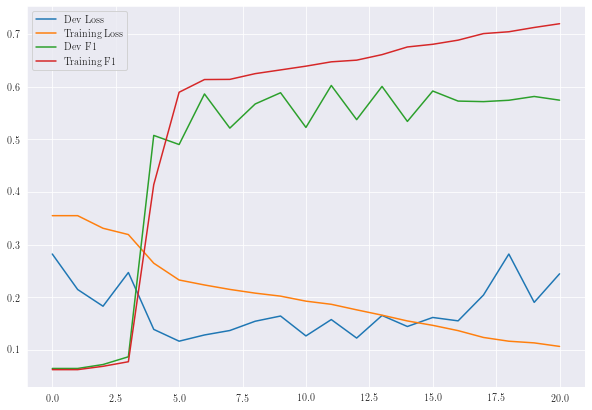

100%|██████████| 7939/7939 [07:14<00:00, 18.27it/s]


Starting evaluation for loss function.
Starting evaluation for dev F1
Finished Training


In [24]:
%matplotlib inline

# Deben ir en la misma celda donde se entrena, de lo contrario no fija la semilla
torch.manual_seed(42)

# try2
HIDDEN_DIM = 600
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, 6, 0.2, vocab.vectors, HIDDEN_DIM, len(vocab.vectors))
model.to(torch.device(dev)) # Lo mueve a la GPU, en caso de que haya
# model.cuda()              # Pasa todo a la GPU, da error si no hay GPU

criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), momentum = 0.85, lr=0.0005)
optimizer = optim.Adam(model.parameters())

# Antes eran 100
stop_after_best = 10
# Nombre del archivo de backup
savefile = 'Models/best-model-try2.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

# Se itera hasta que no mejore el desempeño en dev por 'stop_after_best' épocas
while epochs_without_change < stop_after_best:  
    display.clear_output(wait=True)
    print("Training on: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training F1 is: " + str(best_tl))
    print("[Best iter] dev F1 is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training F1 was: " + str(f1_scores_train[-1]))
    print("[Last iter] dev. F1 was: " + str(f1_scores_dev[-1]))
    print("###############################################")
    #Dibujo lo que puedo
    plt.figure(figsize=(10,7))
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_scores_dev)
    plt.plot(range(epochs), f1_scores_train)
    plt.legend(["Dev Loss", "Training Loss", "Dev F1", "Training F1"])
    plt.show()
    
    tl = 0
    t_pred_l = []
    t_true_index_l = []
    t_tokenized_l = []
    t_text_l = []
    for i,v in tqdm(enumerate(trainloader), total=len(trainloader)): #Not using batches yet
        text = torch.reshape(v['text'], (-1,))
        tags = torch.reshape(v['spans'], (-1,))
        optimizer.zero_grad()
        tag_scores = model(text)
        
        #Para la F1
        t_pred_l.append(tag_scores.cpu().detach().numpy())
        t_true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
        t_tokenized_l.append([a[0] for a in v['tokenized']])
        t_text_l.append(v['original_text'][0])
        
        loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
        tl += loss.item()
        loss.backward()
        optimizer.step()

    tl /= len(trainloader)
    l = 0
    print("Starting evaluation for loss function.")
    # evaluar el modelo
    pred_l = []
    true_index_l = []
    tokenized_l = []
    text_l = []
    
    model.eval()
    with torch.no_grad():
        for v in testloader:
            text = torch.reshape(v['text'], (-1,))
            tags = torch.reshape(v['spans'], (-1,))

            tag_scores = model(text)
            
            #Para la F1
            pred_l.append(tag_scores.cpu().detach().numpy())
            true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
            tokenized_l.append([a[0] for a in v['tokenized']])
            text_l.append(v['original_text'][0])
            
            loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
            l += loss.item()
    model.train()
    l /= len(testloader)
    print("Starting evaluation for dev F1")
    f1_d = f1_scores(pred_l, true_index_l, tokenized_l, text_l)
    # Es aproximado, pero solo es una referencia
    f1_t = f1_scores(t_pred_l, t_true_index_l, t_tokenized_l, t_text_l) 
    
    
    epochs_without_change += 1
    if best_l is None or best_l < f1_d:
        print("Model improved, saving.")
        torch.save(model, savefile)
        best_l = f1_d
        best_tl = f1_t
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    # Para graficar con una escala coherente.
    if(worst_l_f1 is None or f1_d < worst_l_f1):
        worst_l_f1 = f1_d
        f1_scores_dev[0] = worst_l_f1
    if(worst_tl_f1 is None or f1_t < worst_tl_f1):
        worst_tl_f1 = f1_t
        f1_scores_train[0] = worst_tl_f1
    if(worst_tl is None or tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl
    if(worst_l is None or l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    # Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_scores_train.append(f1_t)
    f1_scores_dev.append(f1_d)
    # Rastreo la época actual
    epochs += 1
print('Finished Training')

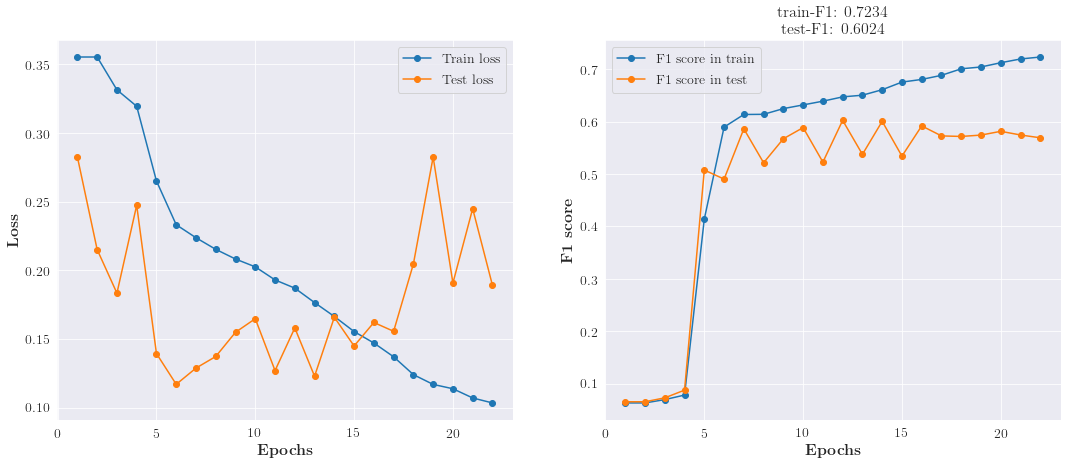

In [25]:
plot_loss_and_score(training_loss, loss_per_epoch, f1_scores_train, f1_scores_dev, show=False)
plt.savefig('../Images/preprocesamiento-2.pdf', bbox_inches='tight')
plt.show()

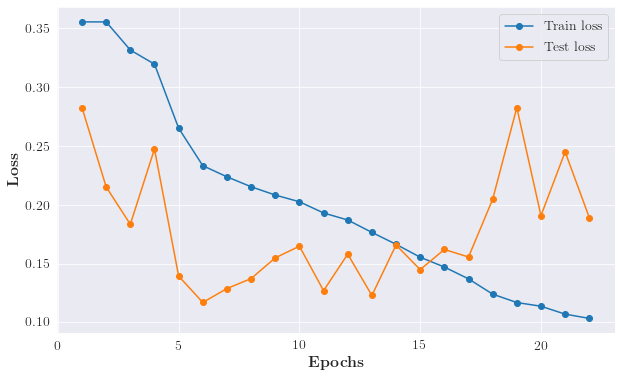

In [26]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, marker='o', label='Train loss')
plt.plot(np.arange(1, len(loss_per_epoch) + 1), loss_per_epoch, marker='o', label='Test loss')
plt.xlabel(r'\textbf{Epochs}',size=16)
plt.ylabel(r'\textbf{Loss}', size=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.savefig('../Images/preprocesamiento-2-1.pdf', bbox_inches='tight')
plt.show()

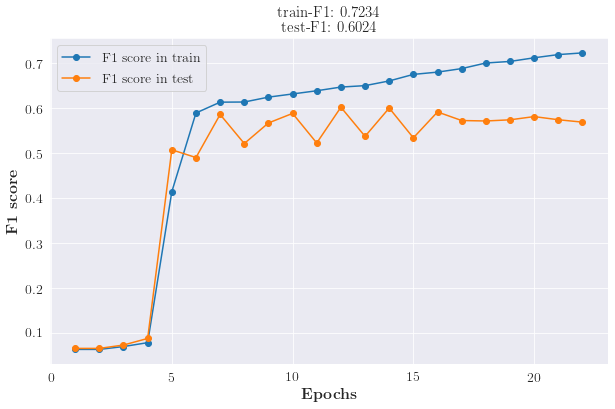

In [27]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, marker='o', label='F1 score in train')
plt.plot(np.arange(1, len(f1_scores_dev) + 1), f1_scores_dev, marker='o', label='F1 score in test')
plt.xlabel(r'\textbf{Epochs}',size=16)
plt.ylabel(r'\textbf{F1 score}', size=16)
plt.tick_params(labelsize=14)
title = 'train-F1: {:.4f} \n  test-F1: {:.4f}'.format(np.max(f1_scores_train), np.max(f1_scores_dev))
plt.title(title, size=15)
plt.legend(fontsize=14)
plt.savefig('../Images/preprocesamiento-7-2.pdf', bbox_inches='tight')
plt.show()

Para graficar la red ver [Visualize a net in PyTorch?](https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch)

<a name="Evaluación"></a>
## Evaluación

In [28]:
# model = torch.load('best-model-try2.pt')
# model.eval()

In [30]:
train = pd.read_csv('../Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('../Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})
evaluation = pd.read_csv('../Datos/tsd_test.csv')

train['spans_clean'] = train['spans']
test['spans_clean'] = test['spans']

In [31]:
indices_test = []
for i,(gold_index,text) in enumerate(zip(test['spans_clean'],test['text'])):
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_test.append(prediction_index)
    print(str(i) + colored(' Pred: ', color='cyan', attrs=['bold']) + 
           color_toxic_words(prediction_index, text))
    print(str(i) + colored(' Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)

0 Pred: Because he's a moron and a bigot. It's not any more complicated than that.
0 Gold: Because he's a moron and a bigot. It's not any more complicated than that.


1 Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
1 Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


2 Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
2 Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


3 Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
3 Gold: Trump Claim

6 Pred: Thanks a lot douchebag. You're the reason the Portland buttfuckers are getting pushed out and moving down south to the Wilsonville area and beyond. Because of you all the stupid fucking assholes that made Portland a place full of stupid fucking assholes are going to try to turn Salem into some kind of new-stupid-fucking-asshole-topia. This will drive up the price of housing and displace  people down here. Having lived in San Clemente for a time myself I think you're dumb as shit to have moved up here. The fucks wrong with you outsider. I hope bums shit in your yard everyday and never let you walk by without demanding spare  change.
6 Gold: Thanks a lot douchebag. You're the reason the Portland buttfuckers are getting pushed out and moving down south to the Wilsonville area and beyond. Because of you all the stupid fucking assholes that made Portland a place full of stupid fucking assholes are going to try to turn Salem into some kind of new-stupid-fucking-asshole-topia. This wi

13 Pred: Clinton should be the last person to say anything about anyone. She is such a lying scum bag. I can't handle just hearing her voice. It would be a lot worse if she was President than we are with the crazy Trump. She would have her husband (AKA: as the cigar rapist) as her guide. He should have been arrested for doing that to that young girl, the starred eye Monica. How can anyone blame her but I certainly wouldn't have let him stick a cigar in me. It is the Media's fault because they keep going to get her big lying mouth going.
13 Gold: Clinton should be the last person to say anything about anyone. She is such a lying scum bag. I can't handle just hearing her voice. It would be a lot worse if she was President than we are with the crazy Trump. She would have her husband (AKA: as the cigar rapist) as her guide. He should have been arrested for doing that to that young girl, the starred eye Monica. How can anyone blame her but I certainly wouldn't have let him stick a cigar in 

22 Pred: Clinton signed that Joint Fundraising agreement in August 2015. It was reported on then; why is it an issue now? And there wasn't anything illegal about it, so it's not a crime. Oh, and the Sanders campaign signed the same agreement with the DNC in Oct 2015. Somehow that's overlooked. Though granted, Sanders later chose to raise money on his own, not thru the Fund. No, Clinton hasn't gotten away with "so many crimes," because she hasn't committed them. "It boggles the mind that after all these revelations, people would want a liar and a crook to be our president," clearly refers to Trump; a liar and a crook.
22 Gold: Clinton signed that Joint Fundraising agreement in August 2015. It was reported on then; why is it an issue now? And there wasn't anything illegal about it, so it's not a crime. Oh, and the Sanders campaign signed the same agreement with the DNC in Oct 2015. Somehow that's overlooked. Though granted, Sanders later chose to raise money on his own, not thru the Fund

30 Pred: the sock puppet will do whatever PM Butts tell him to do.
30 Gold: the sock puppet will do whatever PM Butts tell him to do.


31 Pred: Another idiot!
31 Gold: Another idiot!


32 Pred: Invoke a leap year April Fools and put this pathetic rapists away for life without parole.  Let him rot with stale meals and a saggy cot.
32 Gold: Invoke a leap year April Fools and put this pathetic rapists away for life without parole.  Let him rot with stale meals and a saggy cot.


33 Pred: These freaking donkeys all need to be removed from office. I'm so sick and tired of these lifelong politicians who all seem clueless and could never run their own business.

 For all you people who marched against our president how about we all March to Honolulu hale and demand rail be stopped. Oh that's right you only like complaining against the president of the United States and do nothing against all the useless politicians in your own backyard. 
Such hypocrites. Keep voting for those donkeys you foo

39 Pred: Section 160 should also be amended to include sexual acts with animals not involving penetration.
39 Gold: Section 160 should also be amended to include sexual acts with animals not involving penetration.


40 Pred: "Wythe thinks Republican members of the House should settle their differences in caucus meetings — which are private."  That statement should scare the h*ll out of  any voter.  Another advocate for a state government functioning  behind closed doors is exactly who we do not need in the Alaska Legislature.  The  system she apparently adores (the secretive standing caucus system)has just about pounded this state into the ground.  Also, does she understand caucus membership is all about crushing any minority view and has little to do with party platforms and everything to do with the quid pro quo of trading toady behavior for spending in deals that are done behind closed doors?  Stupid is as stupid does..........
40 Gold: "Wythe thinks Republican members of the House 

44 Pred: It's hilarious watching the Trumpniks tying themselves into ridiculous knots in order to support this moron no matter what.



I wonder if they have any /idea/ how ridiculous they look to normal people.
44 Gold: It's hilarious watching the Trumpniks tying themselves into ridiculous knots in order to support this moron no matter what.



I wonder if they have any /idea/ how ridiculous they look to normal people.


45 Pred: Is T-rump really this naive/stupid?
45 Gold: Is T-rump really this naive/stupid?


46 Pred: We aren't California or New York .    You obviously don't pay the ever rising taxes, but I do and the personal  incomes in this town  don't support them and I'm sick of them being raised on a yearly basis to support the freeloaders and things like stupid and unneeded roundabouts so the current mayor can have some sort of legacy after he's booted out of office.
46 Gold: We aren't California or New York .    You obviously don't pay the ever rising taxes, but I do and the

50 Pred: what is too pathetic is the lie you just fell for, no one will loose health care loser, there is to be a national fund to ensure that,,, 
You are the far nut job lunatic left fringe of stupidity
50 Gold: what is too pathetic is the lie you just fell for, no one will loose health care loser, there is to be a national fund to ensure that,,, 
You are the far nut job lunatic left fringe of stupidity


51 Pred: Bull shit. Did I spell that right? Or is it one word: bullshit. Jeff Bezos: do you tremble at the prospect of President Clinton?
51 Gold: Bull shit. Did I spell that right? Or is it one word: bullshit. Jeff Bezos: do you tremble at the prospect of President Clinton?


52 Pred: So if I were to say that Islam is being used to create terrorists, which it is, would that be hatred towards Muslims? 
The gray area on this stupidity is wide and deep.
52 Gold: So if I were to say that Islam is being used to create terrorists, which it is, would that be hatred towards Muslims? 
The gr

60 Pred: In history Englandmen hated to be listed together even with Scots or French, let alone with Irish, Italian, Eastern central European, Russian .... now they want to enlist them to be "white nationalist" with them? 
Ridiculous and coward bunch.
60 Gold: In history Englandmen hated to be listed together even with Scots or French, let alone with Irish, Italian, Eastern central European, Russian .... now they want to enlist them to be "white nationalist" with them? 
Ridiculous and coward bunch.


61 Pred: Having been on Hagemeister and seeing first hand the devastation, the only word in your diatribe that is accurate is 'stupid'. Another example of this man made ecological disaster is at the south end of Umnak Island where feral cattle and sheep have disturbed an archaeological site that is considered the oldest in the Aleutians. I've been there and helped rebury remains that were exposed from the animal caused erosion. To see literally hundreds of remains, exposed hearths and midd

69 Pred: Oh my here we go again.....Another day in the lives of hysterical hypocrite liberals and their Russian Boogey Man conspiracies. Democrats obvisiously  so butthurt over Trumps win that all they have left is impeachment nonsense and verbal attacks to distract the public from their own gross ignorance and anti America, un American direction of their political party.
69 Gold: Oh my here we go again.....Another day in the lives of hysterical hypocrite liberals and their Russian Boogey Man conspiracies. Democrats obvisiously  so butthurt over Trumps win that all they have left is impeachment nonsense and verbal attacks to distract the public from their own gross ignorance and anti America, un American direction of their political party.


70 Pred: If you're dumb enough to believe him on this, then I've got a bridge in Brooklyn I will sell you...
.
The guy is a pathological liar.  Don't believe anything he says.  It's all lies.
70 Gold: If you're dumb enough to believe him on this, t

79 Pred: stupid is as stupid does.....and trump is.........
79 Gold: stupid is as stupid does.....and trump is.........


80 Pred: Hey Dickie, as long as it crushes that smug holier-than-thou attitude held by 90% of Canadians, I'm ok with it.
Shadenfreude's a bitch.
80 Gold: Hey Dickie, as long as it crushes that smug holier-than-thou attitude held by 90% of Canadians, I'm ok with it.
Shadenfreude's a bitch.


81 Pred: F@#k all you libtards. Go move to California so when NKorea nukes it, a  good chunk of you dumba$$es will be gone for good.
81 Gold: F@#k all you libtards. Go move to California so when NKorea nukes it, a  good chunk of you dumba$$es will be gone for good.


82 Pred: Morons are people who take a misstatement and spin it to mean something stupid like saying Trump does not know he is President of the Virgin Island.  He knows.    I remember a candidate for president once saying he had campaigned in 57 states.  I also remember that same person, as President, in a Memorial Da

87 Pred: RE agents are some of the most manipulative narcissist's around.  They lie, lie, lie, cheat, cheat, cheat for breakfast, lunch and dinner. 
-
How do you teach someone to sell their soul?
87 Gold: RE agents are some of the most manipulative narcissist's around.  They lie, lie, lie, cheat, cheat, cheat for breakfast, lunch and dinner. 
-
How do you teach someone to sell their soul?


88 Pred: That's contradicted by the facts. First of all, Democrats have acknowledged the past and the party evolved to the anti-racist side, which prompted southern racists who used to constitute the Solid South for the party to migrate to the GOP, where the South now pretty much votes solidly for Republicans due to the GOP's adoption of the racist polices the Democrats used to push. If there are any remaining racists in the Democratic Party, the members will marginalize and push them out.

The Democratic Party of the 1800s, though, was the conservative party. They were not "leftist" at all.

Entitl

91 Pred: You must not have read the part where I said "on a lighter note " .To a person who just turned on a TV it would look like something out of a crazy comedy movie .  No real hockey fan would want to attend a UAA hockey game and watch that goofball stuff.   You don't see Aces crowds , NHL crowds , or even other college hockey teams fans acting like they all just escaped a trailer park. There's a reason so few attend UAA hockey games----and showing those fans acting loonie tunes is one of the reasons. I was offering advice to help with UAA's pathetic attendance problems---saying don't show stuff like that on TV if you want real hockey fans to attend. I couldn't care in the least if you consider my comments credible or not. The bottom line is :  if UAA wants to draw more fans to games---they'll stop showing crowd shots of craziness .  Fans want to watch the game----not see tons of kids bouncing off the walls .
91 Gold: You must not have read the part where I said "on a lighter note 

96 Pred: I love how fellow troglodytes vote in agreement with you despite your falsehoods.   Let me see our middle class taxes were lowered and this also benefits the wealthy (but yes they did rise for those making over $200k - boo hoo).  Our corporate taxes are already in the 10-15% range and have been for a long time.   So where are these tax increased under Wynne or Trudeau, name them???   

You believe Trump can get rid of half (just a guess) of federal revenue and it will benefit society?  You think that is how it works?  Do tell.   How does the fact that within the next 20 years we will ALL lose another 10-20% of jobs due to technology?  Tell me how that factors in for you?  What about the fact that globally we are adding about 80 million more people a year but require less labour?  How does that factor in, let me tell you?  Should we always just let the .01% reap the benefits of technology none of them have invented?   Simple minded answers are for the far right among us.
96 Gol

107 Pred: Justin Trudeau is too busy with his pay for access Chinese friends and getting advice from and giving taxpayers money to the billionaire Islamic spiritual leader the Aga Khan than worry about the fact that Canadians can't afford to live in their own cities anymore. 

Silly Canadians.
107 Gold: Justin Trudeau is too busy with his pay for access Chinese friends and getting advice from and giving taxpayers money to the billionaire Islamic spiritual leader the Aga Khan than worry about the fact that Canadians can't afford to live in their own cities anymore. 

Silly Canadians.


108 Pred: All you said is true. However, we as viewers aren't the ones responsible for programming. I'm not sure how shows, like  the shows you've listed, or "Amish Mafia," "Mermaids" and the like, fared in focus groups, or who previewed these shows before airing, but clearly, the Cable network thinks we're all a bunch of idiots.
108 Gold: All you said is true. However, we as viewers aren't the ones respo

114 Pred: Trump is too stupid to understand that in provoking China, he is not dealing with a defenseless country like Iraq or Libya. Besides its significant economic power, China is also a nuclear power, and can put together an army ten times the size that Americans can if necessary. Talking big is one thing. Backing it up is another thing entirely. Hopefully the generals and diplomats will be able to straighten Trump out before he does any serious damage.
114 Gold: Trump is too stupid to understand that in provoking China, he is not dealing with a defenseless country like Iraq or Libya. Besides its significant economic power, China is also a nuclear power, and can put together an army ten times the size that Americans can if necessary. Talking big is one thing. Backing it up is another thing entirely. Hopefully the generals and diplomats will be able to straighten Trump out before he does any serious damage.


115 Pred: Yes, he is as stupid as he is portrayed.  I don't hope, I just w

123 Pred: Apparently this nation isn't ready for a woman as president yet, even a highly qualified and intelligent woman with a lot of international diplomatic experience; but it's equally apparent this nation will accept an ignorant man with no governing, diplomatic or military experience, who fobs his business debts of on banks, partners and contractors, lies nonstop, tweets inanely at the wee hours, and has less attention span than a fruit fly.

A college education, as you know, doesn't even guarantee literacy. Most of those voters probably had business degrees, which means, social and economic conservative mixed with social pretenses, bigotry toward working people, and a distrust or disrespect toward women. This election was an eye-opener for me.
123 Gold: Apparently this nation isn't ready for a woman as president yet, even a highly qualified and intelligent woman with a lot of international diplomatic experience; but it's equally apparent this nation will accept an ignorant man w

134 Pred: Trying to determine what the Trump administration will do is impossible. A discussion with Trump is more like organizing an intervention with a psychotic.
We stand our ground and let the chips fall. We'll be just fine.
As the saying goes, Never argue with an idiot. They will only bring you down to their level and beat you with experience.
134 Gold: Trying to determine what the Trump administration will do is impossible. A discussion with Trump is more like organizing an intervention with a psychotic.
We stand our ground and let the chips fall. We'll be just fine.
As the saying goes, Never argue with an idiot. They will only bring you down to their level and beat you with experience.


135 Pred: I know its exactly the same with the morons who conflate footballers and football.
135 Gold: I know its exactly the same with the morons who conflate footballers and football.


136 Pred: Republicans are the cause of the degraded condition of our roads, not bicycles.  We need to tax th

141 Pred: There is no bill. The 2% figure is a guideline. Numerous other countries are below Canada in their contributions and Canada spends a great deal of money on defense related activities that don't qualify for NATO, but do contribute to NATO. Coast Guard, for example. 

In other words, you're whining is misplaced. You've admitted you are an American and no doubt a Trump supporter. Good luck with acquiring support in Canada for that hapless buffoon.
141 Gold: There is no bill. The 2% figure is a guideline. Numerous other countries are below Canada in their contributions and Canada spends a great deal of money on defense related activities that don't qualify for NATO, but do contribute to NATO. Coast Guard, for example. 

In other words, you're whining is misplaced. You've admitted you are an American and no doubt a Trump supporter. Good luck with acquiring support in Canada for that hapless buffoon.


142 Pred: So what if Donald is a liar; he has other good qualities, like being a

150 Pred: "I fly all the time around the world."

No, you do not. You're not an independently wealthy jet setter, and you're not a pilot. You're a retired garbage man.
150 Gold: "I fly all the time around the world."

No, you do not. You're not an independently wealthy jet setter, and you're not a pilot. You're a retired garbage man.


151 Pred: What a circle jerk for all to see in living color . Politically motivated and tax payer funded garbage ! As if we do not have serious crimes to actually look at with Lynch and Comey as well as Hillary and A. Weiner.  Disgusting what these elites get away with and is covered up as SOP .

We all live in many illusions created for us to control us. 
http://www.downtoearththinking.com/the-war-for-our-minds-.html
151 Gold: What a circle jerk for all to see in living color . Politically motivated and tax payer funded garbage ! As if we do not have serious crimes to actually look at with Lynch and Comey as well as Hillary and A. Weiner.  Disgusting wh

157 Pred: h3ll3ry, h3ll3ry--please go away and zip your ugly lying traitorous mug.
157 Gold: h3ll3ry, h3ll3ry--please go away and zip your ugly lying traitorous mug.


158 Pred: http://www.politicususa.com/2016/09/02/trump-craven-maniacal-david-bossie-clinton-character-assassin.html

New Trump Hire Proves Hillary Clinton’s Vast Right Wing Conspiracy is Real
Trump's new Deputy Campaign Manager, Citizens United President David Bossie, "has devoted his career ever since to trying to tear down Hillary Clinton"

There is no disguising the truth: Bossie will be assisting Kellyanne Conway as an anti-Clinton character assassin, and Hillary for America Chair John Podesta released the following statement:

“David Bossie is so craven and maniacal that in the heyday of the overreaching, Gingrich-era Congress, the top Whitewater conspiracy theorist in the House had to fire him for doctoring evidence. He has devoted his career ever since to trying to tear down Hillary Clinton

Another liar just like

165 Pred: Lebrun James is disgusting! I used to like him but he stumped for HRC the biggest most corrupt politician to EVER run and called blacks SUPER OREDATORS and he trashes Trump?? I quit watching NBA because of him and the Seattle Seahawks version of the NBA-GS Warriors! They're friggn racists and I'm DONE! Only college football for me until......let's unite and boycott the NFL/NBA!!! ESPN is dying too thank the lord.....RACIST LIBTARDS
165 Gold: Lebrun James is disgusting! I used to like him but he stumped for HRC the biggest most corrupt politician to EVER run and called blacks SUPER OREDATORS and he trashes Trump?? I quit watching NBA because of him and the Seattle Seahawks version of the NBA-GS Warriors! They're friggn racists and I'm DONE! Only college football for me until......let's unite and boycott the NFL/NBA!!! ESPN is dying too thank the lord.....RACIST LIBTARDS


166 Pred: Shut the fuck up. This man was my father. You have no clue what the cause of this nor the situat

173 Pred: I don't get it. What's wrong with having a lying, ignorant, unethical incompetent with the attention span and emotional immaturity of a child for president?
173 Gold: I don't get it. What's wrong with having a lying, ignorant, unethical incompetent with the attention span and emotional immaturity of a child for president?


174 Pred: Sometimes you have to burn the village in order to save it.
174 Gold: Sometimes you have to burn the village in order to save it.


175 Pred: This is absolutely disgusting. Of course this garbage has an attached emergency clause. Kate Brown and her liberal cronies who proposed this nonsense need to be deported along with all the damn illegals who they want to support with our money. Screw them!
175 Gold: This is absolutely disgusting. Of course this garbage has an attached emergency clause. Kate Brown and her liberal cronies who proposed this nonsense need to be deported along with all the damn illegals who they want to support with our money. Sc

182 Pred: He's a useful idiot - a counterweight to similar out of touch characters such as Maddow and Matthews, who have done their fair share of conspiracy theorizing and conjecture over the last 6 months (most of which have fallen flat - like Maddow's cringe worthy tax return coverage). Difference is, a fringe group within the right follow Jones. Maddow and Matthews on the other hand, are "journalists" on major networks.
182 Gold: He's a useful idiot - a counterweight to similar out of touch characters such as Maddow and Matthews, who have done their fair share of conspiracy theorizing and conjecture over the last 6 months (most of which have fallen flat - like Maddow's cringe worthy tax return coverage). Difference is, a fringe group within the right follow Jones. Maddow and Matthews on the other hand, are "journalists" on major networks.


183 Pred: Are these some of those Russian pieces of crap that they seem to be building all over Alaska. People don't buy that poorly built Russi

189 Pred: Except the darn population keeps rising.
189 Gold: Except the darn population keeps rising.


190 Pred: Awful comment
190 Gold: Awful comment


191 Pred: When will natives clean up their act and stop using the creations of whiteman?   They don't think they have to. They think it is their moral right to tell us everything they don't like about us.   Until they give up  tshirts,  jeans, pizza, cars, trucks and beer they are  nations of hypocrites.
191 Gold: When will natives clean up their act and stop using the creations of whiteman?   They don't think they have to. They think it is their moral right to tell us everything they don't like about us.   Until they give up  tshirts,  jeans, pizza, cars, trucks and beer they are  nations of hypocrites.


192 Pred: These union as---oles don't care about the animals -why are they unionized anyways....th job requires zero educaton, much like most public jobs - the animals are muchsmarterthan these 400 morons
192 Gold: These union as---

195 Pred: This was an active shooter who already killed. I'm not sure this is someone we would ever want back out on the street. Only time will tell. Can't save them all. Personally, I think anyone who shoots 6 year olds should die. I'm not interested in giving killers on a shooting spree second chances. Killing his parent, ok, lots of reasons, he could have been abused, or acting in self-defense. We don't know at this point. But a shooting rampage at an elementary school? Never any kind of reason, it was cold blooded attempted murder. To make it worse, now these victims will have to go through a trial and relive this experience over and over for the next few years. I wish they killed the shooter.
195 Gold: This was an active shooter who already killed. I'm not sure this is someone we would ever want back out on the street. Only time will tell. Can't save them all. Personally, I think anyone who shoots 6 year olds should die. I'm not interested in giving killers on a shooting spree sec

204 Pred: I love Edith and "love to hate" Archie, even if I'm not able to hate the poor rascal.
204 Gold: I love Edith and "love to hate" Archie, even if I'm not able to hate the poor rascal.


205 Pred: More headline-grabbing non-action without substance by the clueless one.
205 Gold: More headline-grabbing non-action without substance by the clueless one.


206 Pred: True, but Gays and Lesbians should show a little restraint in their behavior.  Kissing and making out in front of children is taking it too far.  I read that this is what happened in front of the shooter's little 3 year old boy and that is what set him off.  That kind of behavior by Gays is extremism.
206 Gold: True, but Gays and Lesbians should show a little restraint in their behavior.  Kissing and making out in front of children is taking it too far.  I read that this is what happened in front of the shooter's little 3 year old boy and that is what set him off.  That kind of behavior by Gays is extremism.


207 Pred: 

213 Pred: Honestly Gary you are a moron. Is Trudeau with his bloodline somehow inherently more qualified? Gary, you are the definition of exactly what the entire US media, bowing to Hillary and actually working for her while pretending to be impartial, is also clearly true of the Canadian media. Grow up, stop being a completely out of touch elitist. There is a Canadian running to be a head of a party that cares about the future of this country and who has made it in this world creating jobs and employing people - that does not make him inherently stupid, out of touch, and Trump like - it makes him a caring Canadian that wants to help. I seriously can't stand people like yourself that offer nothing but hot air.
213 Gold: Honestly Gary you are a moron. Is Trudeau with his bloodline somehow inherently more qualified? Gary, you are the definition of exactly what the entire US media, bowing to Hillary and actually working for her while pretending to be impartial, is also clearly true of the

220 Pred: The people "in on this big conspiracy" are Weinstein's actual victims, whose cries over the last several decades are now finally being addressed.

And guess what Dick, it's liberals who have been exposing the "big conspiracy"-
https://www.thewrap.com/media-enablers-harvey-weinstein-new-york-times/amp/
https://www.newyorker.com/news/news-desk/from-aggressive-overtures-to-sexual-assault-harvey-weinsteins-accusers-tell-their-stories

It's predictable though that you would continue to try and deflect this blockbuster Dem scandal- from Weinstein being a huge Dem fundraiser, to the leftists in Hollywood and the media covering and enabling the pervert- and twist this into being a Republican problem.

Weinstein is the face of your pathetic party.

Own him.
220 Gold: The people "in on this big conspiracy" are Weinstein's actual victims, whose cries over the last several decades are now finally being addressed.

And guess what Dick, it's liberals who have been exposing the "big conspir

228 Pred: The economy is stagnant and collapsing.  Who believes we are in a good economic condition? Only the brainwashed who believe the news.  We are about to enter the biggest collapse in human history with the impending death of the US dollar.  Why are people SO CLUELESS? Seriously! We're days away from a massive collapse, people think the economy is ok? WTF?
228 Gold: The economy is stagnant and collapsing.  Who believes we are in a good economic condition? Only the brainwashed who believe the news.  We are about to enter the biggest collapse in human history with the impending death of the US dollar.  Why are people SO CLUELESS? Seriously! We're days away from a massive collapse, people think the economy is ok? WTF?


229 Pred: You are the 'perfect' Democratic IDIOT.
229 Gold: You are the 'perfect' Democratic IDIOT.


230 Pred: My all time favorites are still Wyoming College (spend $20K per year on something slightly more legit than an online diploma mill and live in a trailer in

232 Pred: Human beings are and will always be very nasty creatures. You and I are members of that club. The point I have been trying to make, which evidently you do not want to acknowledge, is that they were significantly less nasty in southern Africa, than elsewhere. You keep throwing up numbers of dead people that obviously exceed the total populations in the geographical areas you identified and that were alive at the time. Kinda makes the epithet you accorded to me as more appropriate to yourself.
232 Gold: Human beings are and will always be very nasty creatures. You and I are members of that club. The point I have been trying to make, which evidently you do not want to acknowledge, is that they were significantly less nasty in southern Africa, than elsewhere. You keep throwing up numbers of dead people that obviously exceed the total populations in the geographical areas you identified and that were alive at the time. Kinda makes the epithet you accorded to me as more appropriate

244 Pred: Talkeetna has never had any problem with Marijuana. I say "Open a pot shop the size of walmart and tell those soccer moms to kiss your butt." It's a free country and pot is legal. Hey soccer moms,go fight something serious like meth.
244 Gold: Talkeetna has never had any problem with Marijuana. I say "Open a pot shop the size of walmart and tell those soccer moms to kiss your butt." It's a free country and pot is legal. Hey soccer moms,go fight something serious like meth.


245 Pred: You are an ignorant A hole
245 Gold: You are an ignorant A hole


246 Pred: with all the ignorant left wingers here perhaps we can get them some help with thier stupidity
246 Gold: with all the ignorant left wingers here perhaps we can get them some help with thier stupidity


247 Pred: Putin is a murdering kleptocrat dictator, and you are a fool.
247 Gold: Putin is a murdering kleptocrat dictator, and you are a fool.


248 Pred: Hopefully we still have NATO allies given the rhetoric of the idio

258 Pred: No, the biggest difference is that Trump is a sulky boy while Putin is a vicious sociopath. Trump will sneer at you in tweets. Putin will have your children killed.
258 Gold: No, the biggest difference is that Trump is a sulky boy while Putin is a vicious sociopath. Trump will sneer at you in tweets. Putin will have your children killed.


259 Pred: Had no idea there were so many stinkin, rotten, douchebag democrats in our great state....wow....
259 Gold: Had no idea there were so many stinkin, rotten, douchebag democrats in our great state....wow....


260 Pred: You TRUMPTARDS are such COMPLETE HYPOCRITES!!!!

Every time I post "TRUMP DEATH SQUADS™," you completely FREAK OUT!!!  

But every time Palin spewed "OBAMA DEATH SQUADS," you chanted it like ZOMBIES!!!

LMAO!!! WHAT FRAUDS! WHAT TOTAL HYPOCRITES!!!! #LOSERS
260 Gold: You TRUMPTARDS are such COMPLETE HYPOCRITES!!!!

Every time I post "TRUMP DEATH SQUADS™," you completely FREAK OUT!!!  

But every time Palin spewed "OB

266 Pred: if you "complain" nicely if you have a problem rather than being a jerk you will get more vouchers/ect. 99% of people are just mean and that will not help you. 

Invest in Boardroom, especially if you want a quiet break from the "puplic", loud kids, ect., Its worth it.
266 Gold: if you "complain" nicely if you have a problem rather than being a jerk you will get more vouchers/ect. 99% of people are just mean and that will not help you. 

Invest in Boardroom, especially if you want a quiet break from the "puplic", loud kids, ect., Its worth it.


267 Pred: I think Americans believe their president should be free to speak to whoever he thinks best.

So PRC can go suck eggs.
267 Gold: I think Americans believe their president should be free to speak to whoever he thinks best.

So PRC can go suck eggs.


268 Pred: You fool. The NEP had nothing to do with world oil  prices dropping to 5 bucks a barrel. 
You must have spent your Ralph bucks.
268 Gold: You fool. The NEP had nothing 

274 Pred: Sick bastards should be shot.
274 Gold: Sick bastards should be shot.


275 Pred: You are a delusional fool.  Not even an entertaining one.  Your are uninformed, paranoid and incapable of original thought.  In other words, a typical Trump supporter.  But come November, you lose.
275 Gold: You are a delusional fool.  Not even an entertaining one.  Your are uninformed, paranoid and incapable of original thought.  In other words, a typical Trump supporter.  But come November, you lose.


276 Pred: Idiot
276 Gold: Idiot


277 Pred: Building rail to reduce traffic by2% = dumb.   Trusting HART and the city to build rail to Ala Moana, even with a 10 year GET extension = dumber.
277 Gold: Building rail to reduce traffic by2% = dumb.   Trusting HART and the city to build rail to Ala Moana, even with a 10 year GET extension = dumber.


278 Pred: Stupid conspiracy tin-foil hat wearers everywhere unite. As if there aren't enough real, actual  problems to deal with. Evidently false and bl

282 Pred: Migawd, the hypocrisy of Liberals knows no bounds.  Scheer is elected leader, and the libs cry "Harperite".  Kenney announces he is running for the leadership race in Alberta, and the libs cry "Harperite".  Dianne Watts mulls running for the BC Liberal leadership position, and the libs cry "Harperite".

Don't like anyone from the right side of the political spectrum, and they are all labelled "Harperites".   And yet if Trudeau does something that critics would have skewered Harper for doing, the lib commentators go silent. Just sayin'.
282 Gold: Migawd, the hypocrisy of Liberals knows no bounds.  Scheer is elected leader, and the libs cry "Harperite".  Kenney announces he is running for the leadership race in Alberta, and the libs cry "Harperite".  Dianne Watts mulls running for the BC Liberal leadership position, and the libs cry "Harperite".

Don't like anyone from the right side of the political spectrum, and they are all labelled "Harperites".   And yet if Trudeau does so

293 Pred: Such venom and hatred.  You probably have a picture of Kathy Griffin in your room.  No cure for stuck on stupid.
293 Gold: Such venom and hatred.  You probably have a picture of Kathy Griffin in your room.  No cure for stuck on stupid.


294 Pred: He is a joke.  He was handed this position on a silver 0latter.  Instead of worrying about climate change, how about doing something for the people of Hawaii.  Also, "his not my president" statement really showed what he thought about the millions of voters who elected Trump.  Its too bad that the people of Hawaii are so ignorant that he will be in office for the rest of his life.  Not much to look forward to.
294 Gold: He is a joke.  He was handed this position on a silver 0latter.  Instead of worrying about climate change, how about doing something for the people of Hawaii.  Also, "his not my president" statement really showed what he thought about the millions of voters who elected Trump.  Its too bad that the people of Hawaii ar

301 Pred: I never thought I'd say this, but I'd vote for Sarah Palin over Dan Sullivan. She's brain damaged but at least she has a pair.
301 Gold: I never thought I'd say this, but I'd vote for Sarah Palin over Dan Sullivan. She's brain damaged but at least she has a pair.


302 Pred: Our politicians take the dumbest political stances and don't realize how pathetic it makes our state look. Chin and the judge are grossly misinterpreting the temporary ban according to their own ideologies. They are proclaiming FALSE NEWS and now our state looks so ignorant.
302 Gold: Our politicians take the dumbest political stances and don't realize how pathetic it makes our state look. Chin and the judge are grossly misinterpreting the temporary ban according to their own ideologies. They are proclaiming FALSE NEWS and now our state looks so ignorant.


303 Pred: Only alien corporations are allowed to own property in the United States.  These imperialist pigs are abusing their power to not uphold thei

309 Pred: Hey Mateo, ever been to Texas? It's the second most diverse state. Lots of black and Hispanic police officers. What a stupid press release.
309 Gold: Hey Mateo, ever been to Texas? It's the second most diverse state. Lots of black and Hispanic police officers. What a stupid press release.


310 Pred: "Homosexual men define their own masculinity."  

It's BS statements like that that invite ridicule.  If you insist on entering the fray in that manner, don't complain when the truth kicks you right in the hiney.  Simply put, it is the antithesis of masculinity for a man to --- I'll remain polite --- have another man sexually.
310 Gold: "Homosexual men define their own masculinity."  

It's BS statements like that that invite ridicule.  If you insist on entering the fray in that manner, don't complain when the truth kicks you right in the hiney.  Simply put, it is the antithesis of masculinity for a man to --- I'll remain polite --- have another man sexually.


311 Pred: And was 

313 Pred: ''The government has already sold about 30 per cent of the shares in Hydro One, and plans to sell another 30 per cent to raise billions of dollars to pay down debt and to fund public transit and infrastructure projects.'' 
Sure. That's what we want. Wynne and her incompetent band of crooks getting access to MORE money. They've already driven the Ontario economy over a cliff. Of course, they'll spend it on paying down the debt (which is Everest-sized, and costs 1 billion dollars each month to service - thanks, Kathy,) and funding infrastructure and transit. Bullfeathers. That cash will disappear into the same black hole as all the rest.They'll burn through that money faster than a wind-driven grass fire. Then, they'll come looking for more. It's what they do, and it's what they've done. A whole lot of their pals will get rich in the process, and the rest of us will be left holding an empty bag. How anyone could believe one word that these lying bunch of thieves says, is astoun

320 Pred: A clueless fool and demagogue like tRump cannot bring it back? Shocker. 


Just like his foolish approach to things like trade and automation are likely to fail, too. 


Unfortunately, far too few of politicians - especially on the right, where late-stage capitalism is an article of faith - are looking at things systemically or even taking advice of experts that do. 


The conspiracy theories and scapegoating that is likely to occur under stupid leadership like Trump as we go through the coming changes are potentially quite dangerous.
320 Gold: A clueless fool and demagogue like tRump cannot bring it back? Shocker. 


Just like his foolish approach to things like trade and automation are likely to fail, too. 


Unfortunately, far too few of politicians - especially on the right, where late-stage capitalism is an article of faith - are looking at things systemically or even taking advice of experts that do. 


The conspiracy theories and scapegoating that is likely to occur un

326 Pred: How is it clueless. Humans are encroaching on every wild place. We put trails through the wilderness and by salmon streams and then idiots decide that that would be a great place to run or bike through. Where would you like them to go? All animals will report to the top of the peaks and not come down until we're done playing where you eat and sleep. Seriously, instead of making an idiotic remark to make someone mad, why not tell us all where the wild animals should go? We have surrounded them and cut through their homes. We are supposed to be the smartest animals on the planet but still we do these things. Wake up or move back to the lower 48 "freeheels"!
326 Gold: How is it clueless. Humans are encroaching on every wild place. We put trails through the wilderness and by salmon streams and then idiots decide that that would be a great place to run or bike through. Where would you like them to go? All animals will report to the top of the peaks and not come down until we're do

333 Pred: "Salazar said there was no “bad intent” on the part of DiStefano, George or MacIntyre, but rather “mistakes” were made."

Huh! I learned a long time ago in the principle of CYA. When something like this happened in my area of responsibility, I was reaching out to legal and HR to make sure things were handled by the book . .  no looking away.

No bad intent? Don't give me that . . . at best it was gross stupidity coupled with a severe case of willful blindness.
333 Gold: "Salazar said there was no “bad intent” on the part of DiStefano, George or MacIntyre, but rather “mistakes” were made."

Huh! I learned a long time ago in the principle of CYA. When something like this happened in my area of responsibility, I was reaching out to legal and HR to make sure things were handled by the book . .  no looking away.

No bad intent? Don't give me that . . . at best it was gross stupidity coupled with a severe case of willful blindness.


334 Pred: This is disgraceful. For the dems  to 

338 Pred: Quit being a plethora of idiotic statements.
338 Gold: Quit being a plethora of idiotic statements.


339 Pred: These oil soaked clowns in the legislative majorities have drug this out for 5 months now and this is the best they can come up with. If I were Walker I'd plant their asses in Anchorage where the public can get to them for as long as it takes and for as many special sessions as it takes. They've already cost us millions and millions of dollars on garbage that we'll never see a dimes worth of return on, hold their feet to fire until they accomplish the one thing they are paid to do, that is to come up with a viable and sustainable budget FOR THE PEOPLE.
339 Gold: These oil soaked clowns in the legislative majorities have drug this out for 5 months now and this is the best they can come up with. If I were Walker I'd plant their asses in Anchorage where the public can get to them for as long as it takes and for as many special sessions as it takes. They've already cost

346 Pred: Lets just coddle these idiotic standoff perps and let them have their way. Next thing you know bank robbers will be given getaway cars for their timely escape. We dont want these criminals to be late to the next hillary rally.
346 Gold: Lets just coddle these idiotic standoff perps and let them have their way. Next thing you know bank robbers will be given getaway cars for their timely escape. We dont want these criminals to be late to the next hillary rally.


347 Pred: Monsef is an idiot and should be turfed from the Cabinet ....but Comrade Sunny Days is too enamoured with her....
347 Gold: Monsef is an idiot and should be turfed from the Cabinet ....but Comrade Sunny Days is too enamoured with her....


348 Pred: Democrat message: TRUMP IS A BAD GUY. . ..Elect us!
348 Gold: Democrat message: TRUMP IS A BAD GUY. . ..Elect us!


349 Pred: had this happened, had that happened.... so what - how stupid.  He'll never catch Gretzky
349 Gold: had this happened, had that happened..

355 Pred: I don't think the writer of this piece of shit knows what a "white savior complex" is if the jackass did know what it meant he would realize he used it incorrectly, also asians are pretty damn white so using a pathetic virtue signal like that is doesn't apply here, stop cowtowing to the Far Left you little bitch you're white stop self hating just because people have told you to. If you review a film review the damn film don't review society you virtue signaling cunt.
355 Gold: I don't think the writer of this piece of shit knows what a "white savior complex" is if the jackass did know what it meant he would realize he used it incorrectly, also asians are pretty damn white so using a pathetic virtue signal like that is doesn't apply here, stop cowtowing to the Far Left you little bitch you're white stop self hating just because people have told you to. If you review a film review the damn film don't review society you virtue signaling cunt.


356 Pred: What a disaster!!! An Is

367 Pred: Not much to be proud of Sousa, but then again you can't fix stupid
367 Gold: Not much to be proud of Sousa, but then again you can't fix stupid


368 Pred: Trump makes it clear: Trumpcare is all about the tax cuts to the rich.


That part he's crystal clear on, he's not confused or crazy-sounding. 




     He's got this part down pat—taking health care away from millions is going to be a huge boon to the wealthy, 




      "tremendous savings" in taxes.




      That's all this has ever been about—now we've got it straight from the ass's mouth.
368 Gold: Trump makes it clear: Trumpcare is all about the tax cuts to the rich.


That part he's crystal clear on, he's not confused or crazy-sounding. 




     He's got this part down pat—taking health care away from millions is going to be a huge boon to the wealthy, 




      "tremendous savings" in taxes.




      That's all this has ever been about—now we've got it straight from the ass's mouth.


369 Pred: now if Harper wa

378 Pred: Obviously any child can tell this clown is guilty. Once again these dingdongs refuse to follow orders and pull out guns. Guilty. Case closed.
378 Gold: Obviously any child can tell this clown is guilty. Once again these dingdongs refuse to follow orders and pull out guns. Guilty. Case closed.


379 Pred: Yes Randy you are right!!! Why does this make front page news??? I lived in McGrath during the 80's and -50 was a common thing.  Thank goodness the weather has changed or these pansy ass journalists would freeze to death!!!
379 Gold: Yes Randy you are right!!! Why does this make front page news??? I lived in McGrath during the 80's and -50 was a common thing.  Thank goodness the weather has changed or these pansy ass journalists would freeze to death!!!


380 Pred: Sick.  Truly sick.  No doubt you have case citations for us?
380 Gold: Sick.  Truly sick.  No doubt you have case citations for us?


381 Pred: As most people can see, there are the same 4 or 5 people on here who b

386 Pred: So, we create a crap shoot lottery to fund education? Along with closing 1-2 Pioneer Homes (to save money) and throwing seniors out on the street, if I as I suspect many have no place else to go? All to protect the wealthy from paying into a balanced an progressive tax plan?  Is this truly the kind of state we as a collective wish to create? How much lower can our Republican lead Senate drop to? 

I have no kids to educate nor do I have any family or anyone I know living in a Pioneer Home (so I have no stake in this), but I do know that I am willing to pay into a progressive income and/or sales tax within a balanced plan to insure that seniors are housed and that your kids are educated. 

This is about creating a common sense, responsible, balanced, and compassionate Alaskan society for all, not an everyone for themselves, statewide dystopia. 

This is not fiscal responsibility; this is fiscal idiocy.
386 Gold: So, we create a crap shoot lottery to fund education? Along with 

396 Pred: The president is obviously mentally ill.  This is not how a 71 year old man acts - ever.  Even his worshipers are finally - at long last - beginning to understand the depths of his multiple personality defects and his cartoon-like incompetence.

Trump must be removed from office.
396 Gold: The president is obviously mentally ill.  This is not how a 71 year old man acts - ever.  Even his worshipers are finally - at long last - beginning to understand the depths of his multiple personality defects and his cartoon-like incompetence.

Trump must be removed from office.


397 Pred: Dear Brad Sherman liberal idiot. 

I have printed out your "articles of impeachment" ,, WHICH I AM NOW USING TO WIPE MY DIARRHETIC ARSE.  That's what I think  of YOU and your "articles".
397 Gold: Dear Brad Sherman liberal idiot. 

I have printed out your "articles of impeachment" ,, WHICH I AM NOW USING TO WIPE MY DIARRHETIC ARSE.  That's what I think  of YOU and your "articles".


398 Pred: Whoever wr

406 Pred: "Black males are disproportionately shot by police." Go on... what else is disproportionate about black male behavior? You're so close but just won't put your finger on it, will you Washington Post? Honestly, committing 50% of violent crime and only being 25% of those shot by police sounds like it would be evidence of police bias in their favor...
406 Gold: "Black males are disproportionately shot by police." Go on... what else is disproportionate about black male behavior? You're so close but just won't put your finger on it, will you Washington Post? Honestly, committing 50% of violent crime and only being 25% of those shot by police sounds like it would be evidence of police bias in their favor...


407 Pred: Hang this guy and his pilau wife.
407 Gold: Hang this guy and his pilau wife.


408 Pred: Sluts come in both male and female.  

When two sluts fornicate without simple, cheap, readily available contraception (supposedly from Planned Parenthood) unwanted children are 

414 Pred: Maybe it's time to deport Ezra.  After all his lies, propaganda and racism, he has no place in this great country.  Such a sad, loser.
414 Gold: Maybe it's time to deport Ezra.  After all his lies, propaganda and racism, he has no place in this great country.  Such a sad, loser.


415 Pred: Agreed. You can't reach the lost by being a judgmental jerk who makes kids cry. Christ calls real Christians to be compassionate and come along side people in there darkest days, not yell at them to repent as they come out of the bar. There's a time to talk about the consequences of sin but if you don't be compassionate first, nobody will care about what you have to say. Plus, a position of judgment is the worst place to preach from about sin. Paul constantly used his past to lovingly show that he understood where they were right then and he accepted them. When you can say "look, I've been where you are and have felt what you feel", you will have much more of an impact. When people act lik

420 Pred: As one poster here Sid after the election 'If you didn't see it coming (Trump's victory), you were probably part ot eh reason he was elected'. Now that Trump is President, Liberal/left/progressives are clinging to the narrative that he was elected by indecent/ignorant people. They keep digging themselves in further with their belief in their moral superiority although it simply offers more offence to those who they demean. The fact is that Liberal/left/progressive dogma has lost a great deal of credibility with a significant number of Americans (and Canadians) and self-righteously indignant rants by the die-hards simply confirm the validity of the choice made.
420 Gold: As one poster here Sid after the election 'If you didn't see it coming (Trump's victory), you were probably part ot eh reason he was elected'. Now that Trump is President, Liberal/left/progressives are clinging to the narrative that he was elected by indecent/ignorant people. They keep digging themselves in fu

429 Pred: Just stop.  The people who did that with Obama were jerks and morons, not representing the "right".  Same with this trashy mess.  I know many liberal types who are disgusted by the ever-annoying Ms. Griffin.  

Not everything breaks out along party lines and every sane person better hope we never get to that point. If we do, we lose our moral compass and any concept of right vs wrong.
429 Gold: Just stop.  The people who did that with Obama were jerks and morons, not representing the "right".  Same with this trashy mess.  I know many liberal types who are disgusted by the ever-annoying Ms. Griffin.  

Not everything breaks out along party lines and every sane person better hope we never get to that point. If we do, we lose our moral compass and any concept of right vs wrong.


430 Pred: Kim doesn't have what it takes to fire a missile
at the US. Now pile on more sanctions until his
people turn on him and put him and family to
death.
430 Gold: Kim doesn't have what it takes to

436 Pred: Lol really. No offence but that’s an idiotic statement. I’m not looking for likes from the douches on the left/ right political side of things. You can’t honestly think this though. Our government federally and provincially across Canada works exactly like this. The more money in the more money spent. It is always, and will always be spent with little oversight, common sense, little efficiency. That’s it. You see provinces with hst taxing more that have massive debts. Obviously more money didn’t make them better money managers, quite the opposite actually. They post phony  surpluses but debts are ever increasing. The problem is the way money is spent. That’s it. Bloated public sectors that’s sole obligation is to become more bloated. What bloats more then more money. Don’t be naive to think less equalization would magically turn these inept politicians to manage money any better. That includes cons, libs, and dippers. They have zero sense of money management and probably neve

446 Pred: LMAO I just heard a delusional Snowflake make the most stupid remark. "Expressing their 1st Amendment rights with a Violent Protest" HUH! 1st amendment is a Peaceful Demonstration. A Violent Protest is a RIOT...FYI Pelosi is Senile,CA keeps voting her in and the Democrats in the House keep voting her Minority Leader enuf said...
446 Gold: LMAO I just heard a delusional Snowflake make the most stupid remark. "Expressing their 1st Amendment rights with a Violent Protest" HUH! 1st amendment is a Peaceful Demonstration. A Violent Protest is a RIOT...FYI Pelosi is Senile,CA keeps voting her in and the Democrats in the House keep voting her Minority Leader enuf said...


447 Pred: The US is one sick crazy hell of a place.   UNBELIEVABLE !!
447 Gold: The US is one sick crazy hell of a place.   UNBELIEVABLE !!


448 Pred: Incompetent moronic children? Please explain...
448 Gold: Incompetent moronic children? Please explain...


449 Pred: Lets see, you say BCers are "Selfish Liars" an

452 Pred: Shawn Spicer is dishonest scum.

He spent months trying but failing at defending the indefensible.

He doesn't come out the other side of that clean.

He's scum.
452 Gold: Shawn Spicer is dishonest scum.

He spent months trying but failing at defending the indefensible.

He doesn't come out the other side of that clean.

He's scum.


453 Pred: This mo-fo be black! How he be aress? Blm need to get they ass over there an be protess this injustis agains they own! How dare this bro be arres?

Pardon the vernacular here, but, hey, he be a rapper!
453 Gold: This mo-fo be black! How he be aress? Blm need to get they ass over there an be protess this injustis agains they own! How dare this bro be arres?

Pardon the vernacular here, but, hey, he be a rapper!


454 Pred: No it doesn’t.  Talking about superstition RP, you still believe in Hillary Clinton.  Sorry, I didn’t mean to mock your false god.
454 Gold: No it doesn’t.  Talking about superstition RP, you still believe in Hillary C

462 Pred: What a crock, AT. Now you are implying that every Muslim is dedicated to killing "unbelievers". Do you believe that? Such a belief can, and has been used to commit violence against Muslims, including murder of peaceful neighbors.

You have talked yourself into a corner, becoming more radical and hateful with each post. You are ranting. I think you just like to hear yourself talk. Your words make you a fool.
462 Gold: What a crock, AT. Now you are implying that every Muslim is dedicated to killing "unbelievers". Do you believe that? Such a belief can, and has been used to commit violence against Muslims, including murder of peaceful neighbors.

You have talked yourself into a corner, becoming more radical and hateful with each post. You are ranting. I think you just like to hear yourself talk. Your words make you a fool.


463 Pred: You are both pig ignorant and a liar.
463 Gold: You are both pig ignorant and a liar.


464 Pred: Let the malignant narcissist and mentally derang

472 Pred: Trump's Fascist message is the last thing we need in Canada. What we need to do is offer to the world an alternative message, one of reason and tolerance, of decency and peace. The world does indeed need more Canada and for Leitch to suggest otherwise shows she knows nothing at all about what it means to be Canadian. Shame on her for this appalling statement.
472 Gold: Trump's Fascist message is the last thing we need in Canada. What we need to do is offer to the world an alternative message, one of reason and tolerance, of decency and peace. The world does indeed need more Canada and for Leitch to suggest otherwise shows she knows nothing at all about what it means to be Canadian. Shame on her for this appalling statement.


473 Pred: Darn it. (edited) ---- Bingo!
473 Gold: Darn it. (edited) ---- Bingo!


474 Pred: An idiot named Hillary happened
474 Gold: An idiot named Hillary happened


475 Pred: Is there a reason you post nonsense?  Or are you truly so out of it that you

484 Pred: We have people who use the handle "TRUMP IS SIMPLY A VACUOUS BUFFOON And a petty con man. And a traitor", and THIS is considered acceptable and meeting the "civility" standard but the following is not????

"This is another Trump game ... sort of like tweeting "COFEFE". He was playing with Comey so that Comey wasn't sure how far he could carry any lies. Trump has probably been enjoying watching the liberal media twisting themselves in knots over yet another innocent comment (he never said any tapes were made, only that Comey better hope there weren't any)!! Good on ya' Mr. President ... keep playing with these liberal media morons until the world finally sees the buffoons they are!!!"

Really??????????

The "civility" standards are a joke!!!!
484 Gold: We have people who use the handle "TRUMP IS SIMPLY A VACUOUS BUFFOON And a petty con man. And a traitor", and THIS is considered acceptable and meeting the "civility" standard but the following is not????

"This is another Trump

491 Pred: Wow! You are one venom-filled zealot.

Let me just ask one very simple question: Have you ever met Ron and had a conversation with him and his wife, Janet?

If you had any integrity, you would own your comments attacking a very decent, modest individual, by posting under your real name.

But you are sick with your irrational fanaticism and afraid to come out of your "spider hole." You've made clear from past posts that you haven't the foggiest idea of the actual facts regarding the community or the radical zone change. But you have some weird delusion that you know best about what's good for society, and yet you are pathetically ignorant and without any evidence of empathy or human compassion.

Please, get some counseling.

-- Paul
491 Gold: Wow! You are one venom-filled zealot.

Let me just ask one very simple question: Have you ever met Ron and had a conversation with him and his wife, Janet?

If you had any integrity, you would own your comments attacking a very decent, mo

500 Pred: re: Everyone who owns a house has benefited from idiotic rises in housing prices.

No, only people who have sold (and not re-bought, or re-bought, but in a cheaper geographical market than they sold) have benefitted. People that think they benefitted, by taking out equity to reno or do other things with, but have not sold, or have sold and "upgraded" will not have benefitted as a portion of their "equity" will disappear over the next couple of years with rate increases and probably will not return for a very long time (decade or so). Everybody else who just live in their homes and didn't borrow anything against them as they skyrocketed in value, how have they benefitted?
500 Gold: re: Everyone who owns a house has benefited from idiotic rises in housing prices.

No, only people who have sold (and not re-bought, or re-bought, but in a cheaper geographical market than they sold) have benefitted. People that think they benefitted, by taking out equity to reno or do other things 

513 Pred: Just think, we could have sane government right now but for the idiots who backed the narcissistic, war-mongering, corrupt, pathologically lying, sociopathic, fraudulent creep currently in the Whine House. He makes my skin crawl too.  
Trump supporters and the GOP have forever lost any credibility they once had. 

Truly pathetic. 

Time for a revolution (with a nod to Wolf).
513 Gold: Just think, we could have sane government right now but for the idiots who backed the narcissistic, war-mongering, corrupt, pathologically lying, sociopathic, fraudulent creep currently in the Whine House. He makes my skin crawl too.  
Trump supporters and the GOP have forever lost any credibility they once had. 

Truly pathetic. 

Time for a revolution (with a nod to Wolf).


514 Pred: blow harder. what a blow job
514 Gold: blow harder. what a blow job


515 Pred: Pierre giving Albertans the finger, then the shaft (national energy program). years later Liberal Scott Reid saying Alberta Can _low

523 Pred: Ummm...why are you so obsessed with Johann? You seem insecure. Kinda pathetic dude.
523 Gold: Ummm...why are you so obsessed with Johann? You seem insecure. Kinda pathetic dude.


524 Pred: You, sir, are an idiot.
524 Gold: You, sir, are an idiot.


525 Pred: Save it. Damn the developers.
525 Gold: Save it. Damn the developers.


526 Pred: Well we know he is a wanker
526 Gold: Well we know he is a wanker


527 Pred: Look: the village idiot!
527 Gold: Look: the village idiot!


528 Pred: It can also be used satirically, to poke fun at the stupid and ignorant. I like to do that now and then.
528 Gold: It can also be used satirically, to poke fun at the stupid and ignorant. I like to do that now and then.


529 Pred: This is what's dreadfully wrong with our so-called judicial system; criminals can do harm and get away with it.  I don't  care if the spouse went along to get along with her husband.  Children were sexually abused and didn't even know that the sexual predator was pl

533 Pred: I thought that Austen Ivereigh's analysis was quite good and it was telling that Burke's fingers were all over this and that he was the one who was urging Festing to overreact.  I am glad that Pope Francis has been blessed with such a bumbling fool as his main opponent.
533 Gold: I thought that Austen Ivereigh's analysis was quite good and it was telling that Burke's fingers were all over this and that he was the one who was urging Festing to overreact.  I am glad that Pope Francis has been blessed with such a bumbling fool as his main opponent.


534 Pred: Close the MSM down, get rid of the jews that run them..they are the problem
534 Gold: Close the MSM down, get rid of the jews that run them..they are the problem


535 Pred: That's stupid.
535 Gold: That's stupid.


536 Pred: you mean NOT Russia?

you know since Trump was elected  and even before he made a commitment to take on Islamic State even if that meant working with the big bad Russian's doing it. Flynn took a hit  

539 Pred: As a general rule: nearly all assisted living homes are a (legal) scam. As an EMT, I go to these horrible places on the daily.  The rules and regulations are thin, the medical care received is suspect, and the money commanded by these glorified halfway houses for the elderly is laughable. 
 Where I work, there is one on nearly every suburban street. There are so many, even if the regulators were doing their job, they have far too few to tackle this epidemic. This is why things like this happen. I assure you that this is not an isolated case of fraud.
 What is worse, however, is the neglect and abuse that our older generations are suffering. It's disgusting. We allow people with minimal qualification take care of very ill people. And we're surprised when they start stealing from the vulnerable?!?!?!
 I have been to jail and the living in THE VAST MAJORITY of these homes and skilled nursing facilities IS NO DIFFERENT.  CONGRATULATIONS! You're old! Now go to old people jail. Dis

547 Pred: The man is an idiot and I this we would be doing a disservice to prisoners everywhere to suggest that they would admire this jackass.  He was a felon in community custody driving around with drugs and GUNS. He is also a gutless wonder. If he wanted to die he had plenty of heroin and bullets to take care of it without involving the police. He should be charged with a count of  attempted murder for every bullet he fired after he was traffic stopped.  He doesn't look smug to me, he looks stupid .
547 Gold: The man is an idiot and I this we would be doing a disservice to prisoners everywhere to suggest that they would admire this jackass.  He was a felon in community custody driving around with drugs and GUNS. He is also a gutless wonder. If he wanted to die he had plenty of heroin and bullets to take care of it without involving the police. He should be charged with a count of  attempted murder for every bullet he fired after he was traffic stopped.  He doesn't look smug to me, 

556 Pred: Yeah, pretty stupid black&white picture of the world, it's characteristic for autistic children. "We are good and very smart... because we are western people. Russians are evil and blind.... because they are Russians". Your imagination is the only fakes of the Western media - you live in a dream world.
Wake up.
556 Gold: Yeah, pretty stupid black&white picture of the world, it's characteristic for autistic children. "We are good and very smart... because we are western people. Russians are evil and blind.... because they are Russians". Your imagination is the only fakes of the Western media - you live in a dream world.
Wake up.


557 Pred: Seems like your'e the one always bitching about the results of a hurtful Gmt.  Seems like only yesterday you said.

"public office seats who created the homeless problem in the '60s and decade after decade have ignored their mess at best and actually made it far worse. now we have the epitome of stupidity in completely criminalizing those s

562 Pred: Roll a vehicle in a neighborhood = drunk, stupid or both. He's one lucky guy. Kudos to the citizens who helped out.
562 Gold: Roll a vehicle in a neighborhood = drunk, stupid or both. He's one lucky guy. Kudos to the citizens who helped out.


563 Pred: ...another idiot quoting idiots in history. You made the day.
563 Gold: ...another idiot quoting idiots in history. You made the day.


564 Pred: No 
............ he is just trying to keep Putin and 'associates' from calling his loans.
.
Just connect the dots.
Who would lend money to a spoiled idiot after 4 bankruptcies ?
564 Gold: No 
............ he is just trying to keep Putin and 'associates' from calling his loans.
.
Just connect the dots.
Who would lend money to a spoiled idiot after 4 bankruptcies ?


565 Pred: Fuck you Loudermilk. The citizens of The United States should have rights to concealed carry. Otherwise, good luck with your weaponless defense strategy.
565 Gold: Fuck you Loudermilk. The citizens of The United 

572 Pred: People are morons, this is the media attempting, along with whom I said above, to discredit Trump, this is VERY predictable.
572 Gold: People are morons, this is the media attempting, along with whom I said above, to discredit Trump, this is VERY predictable.


573 Pred: Speaking of lucrative business involving Russia, how much did Clinton get for selling America's strategic uranium to Russia?  Gosh, those darn facts always show libs are a bunch of hypocrites.
573 Gold: Speaking of lucrative business involving Russia, how much did Clinton get for selling America's strategic uranium to Russia?  Gosh, those darn facts always show libs are a bunch of hypocrites.


574 Pred: my god you ignorant left wingers will live in complete stupidity every day with such nonsense.  it was obama that didnt care for people only his legacy when he made insurance so unafordable those millions he added could never use the insurance given the out of site deductables
574 Gold: my god you ignorant le

583 Pred: If I was in the press corp I would ask Trump if he felt that he was being treated like a patsy by the Russians. He has never given a plausible reason for being so fauning towards them.
583 Gold: If I was in the press corp I would ask Trump if he felt that he was being treated like a patsy by the Russians. He has never given a plausible reason for being so fauning towards them.


584 Pred: The only "vile enemy" the country has to be concerned with is Trump, a malignant narcissist who, in his delusional "infinite wisdom", acts as if stupidity is a virtue. If we want to prevent him turning this country into Trumpistan, get him out of office and Make America Great Again.
584 Gold: The only "vile enemy" the country has to be concerned with is Trump, a malignant narcissist who, in his delusional "infinite wisdom", acts as if stupidity is a virtue. If we want to prevent him turning this country into Trumpistan, get him out of office and Make America Great Again.


585 Pred: Right af

593 Pred: I have a theory why people are so stupid in these days. For about 30 years the government instructed people to cut out fat from our diet. Replace it with Carbs. Sugar. The population has gotten sicker and fatter. But also more stupid.
So here it is. The brain is basically fat and protein. Exacly what most people don't eat anymore. So if they don't eat what the brain needs it can not develop.
There it is I got the problem figured out. Eat more Moose and Salmon.
593 Gold: I have a theory why people are so stupid in these days. For about 30 years the government instructed people to cut out fat from our diet. Replace it with Carbs. Sugar. The population has gotten sicker and fatter. But also more stupid.
So here it is. The brain is basically fat and protein. Exacly what most people don't eat anymore. So if they don't eat what the brain needs it can not develop.
There it is I got the problem figured out. Eat more Moose and Salmon.


594 Pred: Had to toss in your racist viewpoint b

605 Pred: Lol, such an idiotic comment.  There's junk food sold all over the damn world.   I live in the village and never fed my kids junk like that. My kids have always had good teeth and still do.   Same goes for majority of my friends and relatives.  You compare us 'filthy natives' to the crack whores in the city whose kids are raised on nasty ass junk food (or no food at all)  well, I'd even tip that bigot at Stampede Aviation to bring me back to the ville.
605 Gold: Lol, such an idiotic comment.  There's junk food sold all over the damn world.   I live in the village and never fed my kids junk like that. My kids have always had good teeth and still do.   Same goes for majority of my friends and relatives.  You compare us 'filthy natives' to the crack whores in the city whose kids are raised on nasty ass junk food (or no food at all)  well, I'd even tip that bigot at Stampede Aviation to bring me back to the ville.


606 Pred: Fellow posters ... a friendly suggestion ...

Before y

613 Pred: The way some of you throw around calling people racist, Nazi sympathizer a is pathetic. You have no argument so you deflect and try to falsely label people. 

Again, I'm from a multi-racial family with black, white, Mexican, Jewish, et al members. And unlike you I have actually had someone in my family murdered by the KKK. 

According to your logic I am racist and anti-Semitic against myself and family. Do you see how ignorant your comment is now? Probably not because you don't deal in reality, only wishful thinking and willful ignorance of said reality.
613 Gold: The way some of you throw around calling people racist, Nazi sympathizer a is pathetic. You have no argument so you deflect and try to falsely label people. 

Again, I'm from a multi-racial family with black, white, Mexican, Jewish, et al members. And unlike you I have actually had someone in my family murdered by the KKK. 

According to your logic I am racist and anti-Semitic against myself and family. Do you see h

620 Pred: SO MUCH WINNING BY NIKKI HALEY - she's going to make a great first woman president (sorry Hillary but no one likes you but everyone likes Nikki Haley, plus she's way better looking and not a lesbian :o
620 Gold: SO MUCH WINNING BY NIKKI HALEY - she's going to make a great first woman president (sorry Hillary but no one likes you but everyone likes Nikki Haley, plus she's way better looking and not a lesbian :o


621 Pred: What an idiot.  I am a CHRISTIAN and I believe in Jesus but there is no harm in this anyway.  It's just a fun thing to do on Christmas.  I knew who Jesus was since I was VERY young and I knew there was no Santa or reindeer that flew.  It's just harmless.  He was way out of line.
621 Gold: What an idiot.  I am a CHRISTIAN and I believe in Jesus but there is no harm in this anyway.  It's just a fun thing to do on Christmas.  I knew who Jesus was since I was VERY young and I knew there was no Santa or reindeer that flew.  It's just harmless.  He was way out of 

628 Pred: I will NEVER watch again!!!!!!!     Roger Goodell  YOU are an ASS!!!!
628 Gold: I will NEVER watch again!!!!!!!     Roger Goodell  YOU are an ASS!!!!


629 Pred: typical hate bases left wing stupidity, this was one great person
629 Gold: typical hate bases left wing stupidity, this was one great person


630 Pred: TDM.. as usual cant debate against facts, proving his stupidity over and over
630 Gold: TDM.. as usual cant debate against facts, proving his stupidity over and over


631 Pred: Too bad they didnt catch him after he killed himself. Would be cheaper for the state. sorry ass pos.
631 Gold: Too bad they didnt catch him after he killed himself. Would be cheaper for the state. sorry ass pos.


632 Pred: Senator Bennett is busy blaming Trump who had nothing to do with Obama Care. I'm surprised there are actually that many stupid people that believe him.
632 Gold: Senator Bennett is busy blaming Trump who had nothing to do with Obama Care. I'm surprised there are actually 

638 Pred: The most pathetic President in history is getting desperate .................
Trump's motto should have been "Make America Desperate and Pathetic Again"
638 Gold: The most pathetic President in history is getting desperate .................
Trump's motto should have been "Make America Desperate and Pathetic Again"


639 Pred: Donald will bury it by saying something stupid, in order to get all the media attention back on him.  He lacks impulse control and simply can't help himself. Narcissists are like that--ya they are...
639 Gold: Donald will bury it by saying something stupid, in order to get all the media attention back on him.  He lacks impulse control and simply can't help himself. Narcissists are like that--ya they are...


640 Pred: No, they as anti-American as it gets. They are nazis. Instead of secede, they should be rounded up and kicked out of the United States. They are the enemies of democracy and human rights. Garbage.
640 Gold: No, they as anti-American as it g

646 Pred: Willfully blind, and ignorant.
646 Gold: Willfully blind, and ignorant.


647 Pred: God, you're an idiot. People who drink water are more likely to drink alcohol when they get older. People who walk are more likely to drive cars. Your logic is as flawed as tanning beds and bicycles. Yes, you make no sense.
647 Gold: God, you're an idiot. People who drink water are more likely to drink alcohol when they get older. People who walk are more likely to drive cars. Your logic is as flawed as tanning beds and bicycles. Yes, you make no sense.


648 Pred: But a stupid HS mascot somehow is relevant to the unhinged left.

Your hypocrisy is showing again and again.
648 Gold: But a stupid HS mascot somehow is relevant to the unhinged left.

Your hypocrisy is showing again and again.


649 Pred: Idiot security guard firing his weapon with people nearby. There must be video somewhere...So, who's in charge of airport video, Securitas?..
649 Gold: Idiot security guard firing his weapon with 

657 Pred: Uh, no.
Millennial are lazy, dodgy (when it comes to work-work, school-work they do alright) and dumb.
They are brainwashed by 13 years of gov't school (e.g. Leftist), four or more years of Leftist college (with a "soft" degree on top of that).
No, we really would NOT be better off if them kind of folk started voting in droves.
657 Gold: Uh, no.
Millennial are lazy, dodgy (when it comes to work-work, school-work they do alright) and dumb.
They are brainwashed by 13 years of gov't school (e.g. Leftist), four or more years of Leftist college (with a "soft" degree on top of that).
No, we really would NOT be better off if them kind of folk started voting in droves.


658 Pred: Are you ILLITERATE, Chuck?
658 Gold: Are you ILLITERATE, Chuck?


659 Pred: why would you want to legislate stupidity?
659 Gold: why would you want to legislate stupidity?


660 Pred: The Denver Donkeys are back!  The special teams coach, McCoy and the head coach should lose their jobs.  You put a guard in 

668 Pred: I will fight the White Nationalists along side you. Again, the assumptions.
668 Gold: I will fight the White Nationalists along side you. Again, the assumptions.


669 Pred: One can only hope they are this stupid !!! Lol
But - the democrats reaction and conduct to Trump being elected clearly demonstrates they are just plain Hippocrates and encourage violence to support their agenda!
669 Gold: One can only hope they are this stupid !!! Lol
But - the democrats reaction and conduct to Trump being elected clearly demonstrates they are just plain Hippocrates and encourage violence to support their agenda!


670 Pred: Hot Wire Electric will be paying serious damages for their stupidity.
670 Gold: Hot Wire Electric will be paying serious damages for their stupidity.


671 Pred: And yet you don't condemn the outright racism, bigotry and thuggery of BLM and antifa. That makes you EXACTLY the same as any other racist bigot and thug. Must suck to be you.
671 Gold: And yet you don't cond

676 Pred: I've never before seen so much ignorance in a single post. You have absolutely no clue what you're taking about. The sheer level of stupidity you managed to cram into just a few sentences is amazing. How can someone be so utterly wrong on so many levels.
676 Gold: I've never before seen so much ignorance in a single post. You have absolutely no clue what you're taking about. The sheer level of stupidity you managed to cram into just a few sentences is amazing. How can someone be so utterly wrong on so many levels.


677 Pred: Thank you Secretary Mnuchin!
Do not let the hypocrites win.
677 Gold: Thank you Secretary Mnuchin!
Do not let the hypocrites win.


678 Pred: You're a fake, alright...
678 Gold: You're a fake, alright...


679 Pred: Grand standing egomaniacs?   Oh I get it, unlike Trump and Clinton right?   The Dems and the Reps are two sides of the same corrupt coin, if you want the same old crap feel free to vote for the same old crap.
679 Gold: Grand standing egomania

687 Pred: I think it conservative idiots who cannot react in proportion.
687 Gold: I think it conservative idiots who cannot react in proportion.


688 Pred: You're an id*ot...Go away.
688 Gold: You're an id*ot...Go away.


689 Pred: Unless there is wording in the employment contract saying otherwise, then they (or you, or I, or anybody) can indeed be fired for being stupid or arrogant. Or for driving the wrong color car. Or because our boss is having a really bad day. In Oregon, you can be fired for any reason whatsoever with the exceptions on the short list of prohibited reasons (race, gender, etc.)
689 Gold: Unless there is wording in the employment contract saying otherwise, then they (or you, or I, or anybody) can indeed be fired for being stupid or arrogant. Or for driving the wrong color car. Or because our boss is having a really bad day. In Oregon, you can be fired for any reason whatsoever with the exceptions on the short list of prohibited reasons (race, gender, etc.)




In [32]:
score_test = [f1(pred, gold) for pred,gold in zip(indices_test, test['spans'])]
print('F1 in test: {:.6f}'.format(np.mean(score_test)))

F1 in test: 0.613241
